Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

In [200]:
# import packages
import datetime
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


load and display the dataset

In [115]:
df = pd.read_csv('faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


General infos

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [117]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

The dataset has 1941 rows and 34 features, while having 0 null values.
Features have data type int64 and float64.


Statistics about the features

In [118]:
#df_OHE = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


Lower the name of the columns

In [119]:
df.columns = map(str.lower, df.columns)

Create a column encoding the anomalies features; this is wrong from a model point of view, but it's useful for exploratory analysis. It will be dropped in the future


In [120]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults'] 
# list of the features of the steel plates
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas'] 

In [121]:
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} # mapper for the encoding

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)

In [122]:
#df.drop(391, inplace = True) # remove troublesome outlier

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#import shap
from sklearn.metrics import accuracy_score
import numpy as np

In [124]:
X = df[feat_col]
y = df['anomaly']

In [125]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state=42) # Split dataset into 75% train and 25% test
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [126]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7839506172839507

In [127]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feat_col, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                  Feature  Gini Importance
10     length_of_conveyer         0.062912
21             logofareas         0.062063
22            log_x_index         0.054790
4            pixels_areas         0.053074
13  steel_plate_thickness         0.050268
0               x_minimum         0.044954
17        outside_x_index         0.043981
7       sum_of_luminosity         0.042486
8   minimum_of_luminosity         0.040723
1               x_maximum         0.040284
24      orientation_index         0.039148
5             x_perimeter         0.037888
14            edges_index         0.037511
19          edges_y_index         0.036915
2               y_minimum         0.035939
3               y_maximum         0.035845
25       luminosity_index         0.034415
16           square_index         0.032363
26         sigmoidofareas         0.031981
9   maximum_of_luminosity         0.030595
15            empty_index         0.030456
18          edges_x_index         0.028273
12       ty

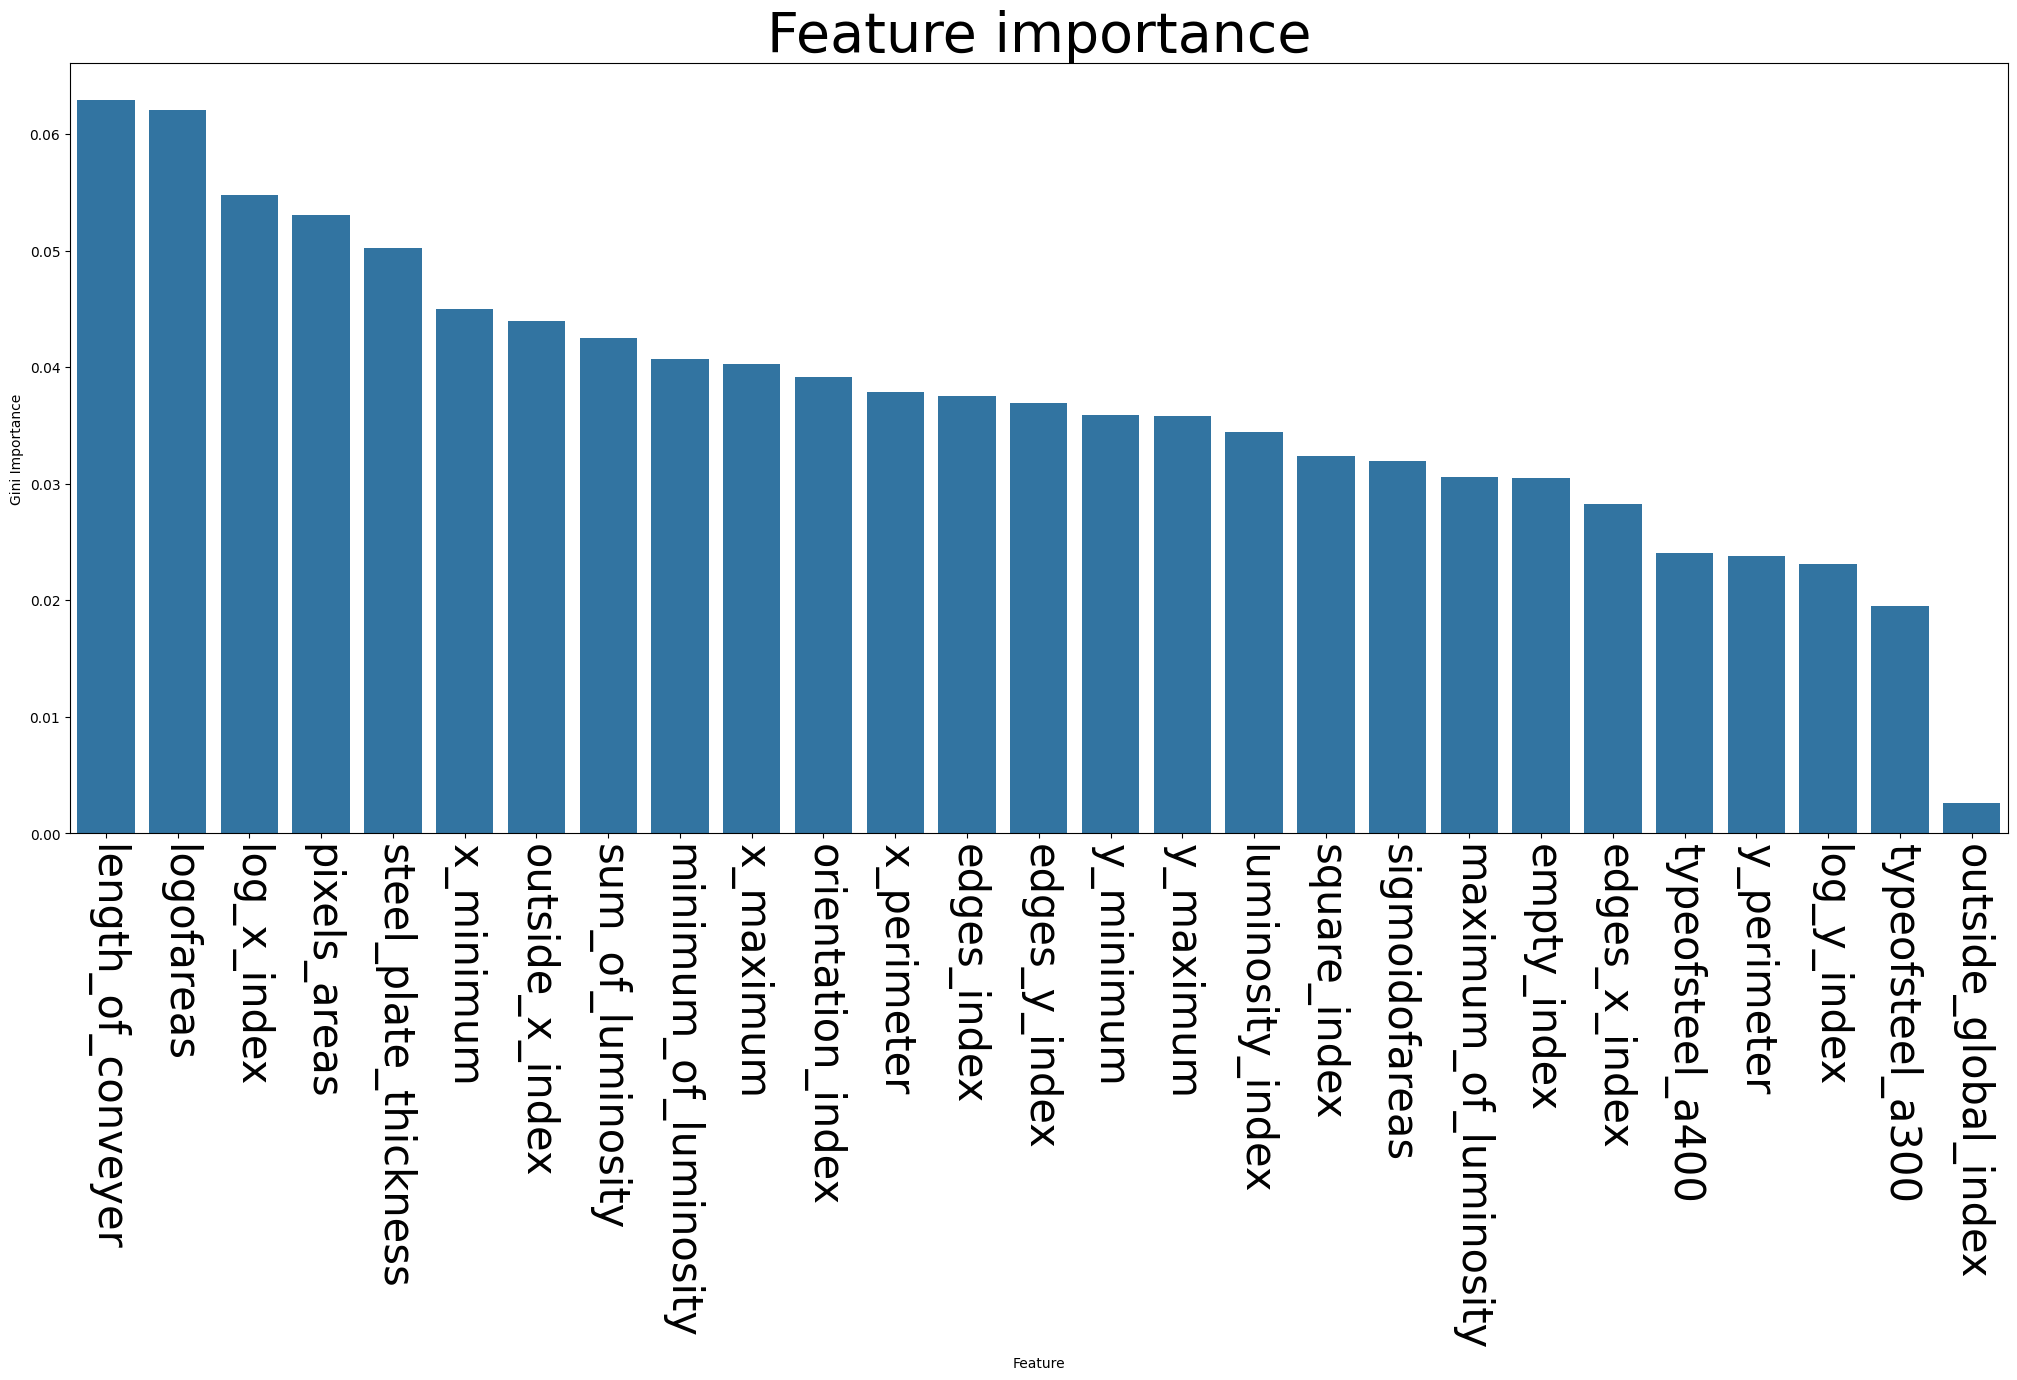

In [128]:
plt.figure(figsize = (25, 10))
plt.title('Feature importance', fontsize = 40)
sns.barplot(feature_imp_df, x = 'Feature', y = 'Gini Importance')
plt.xticks(fontsize = 30, rotation = 270)
plt.show()

## Histograms of the features

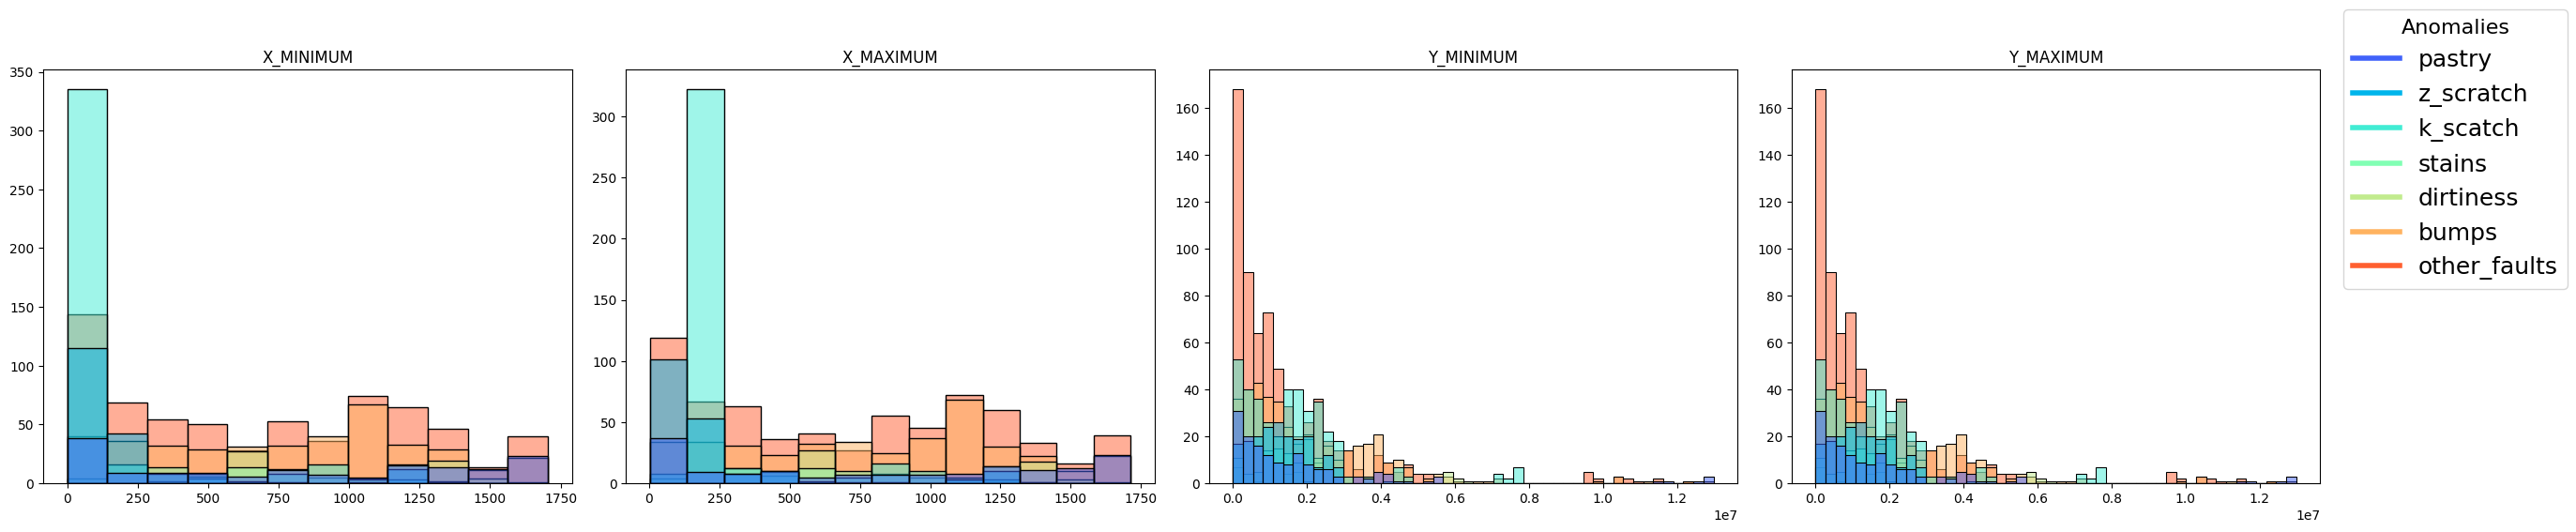

In [129]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('rainbow', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('rainbow', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

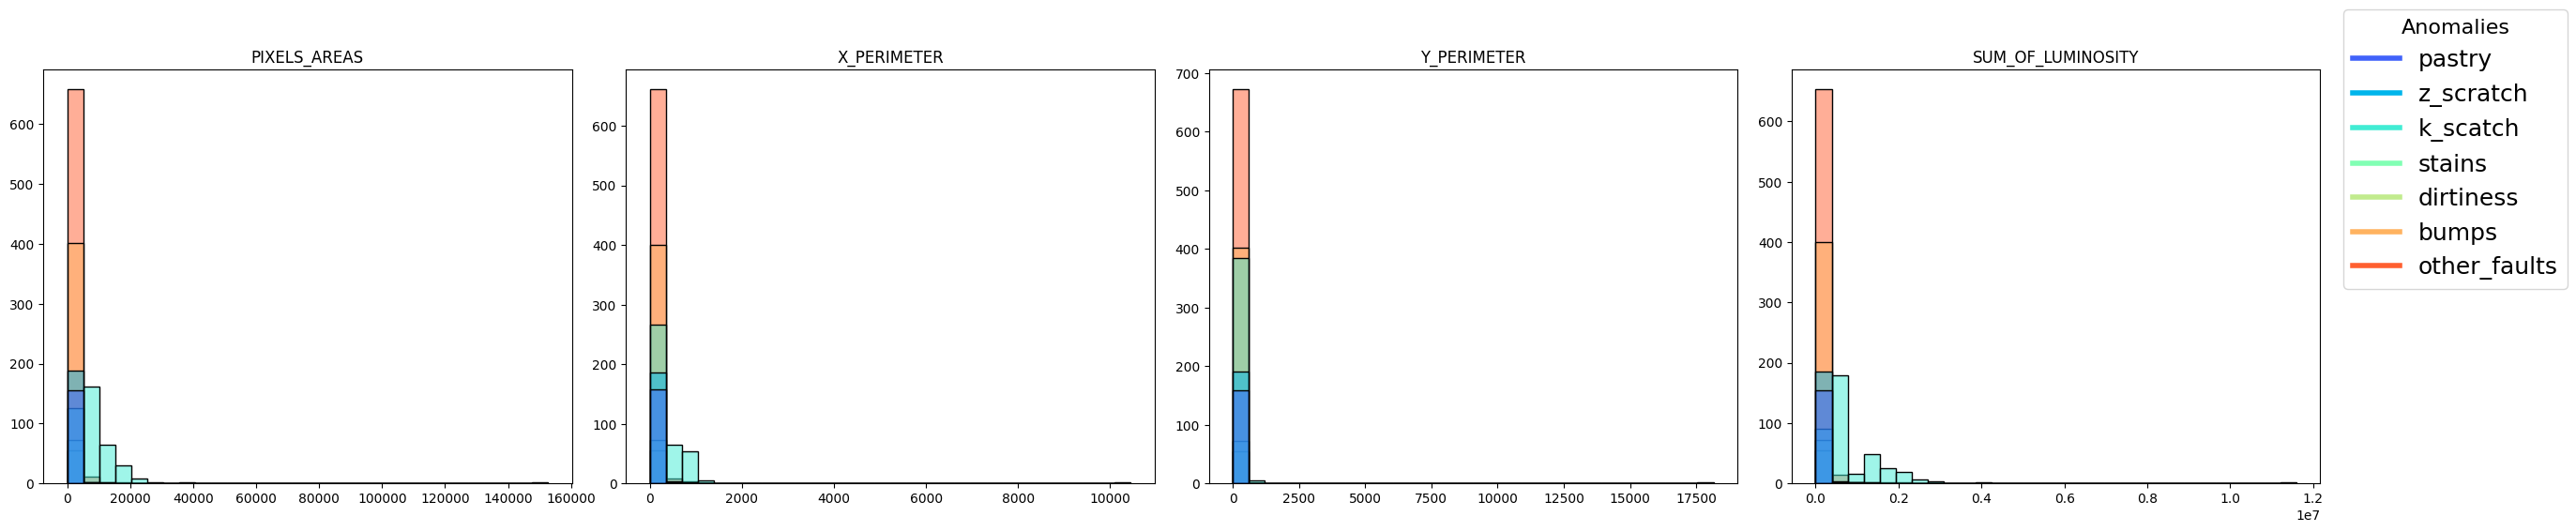

In [130]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

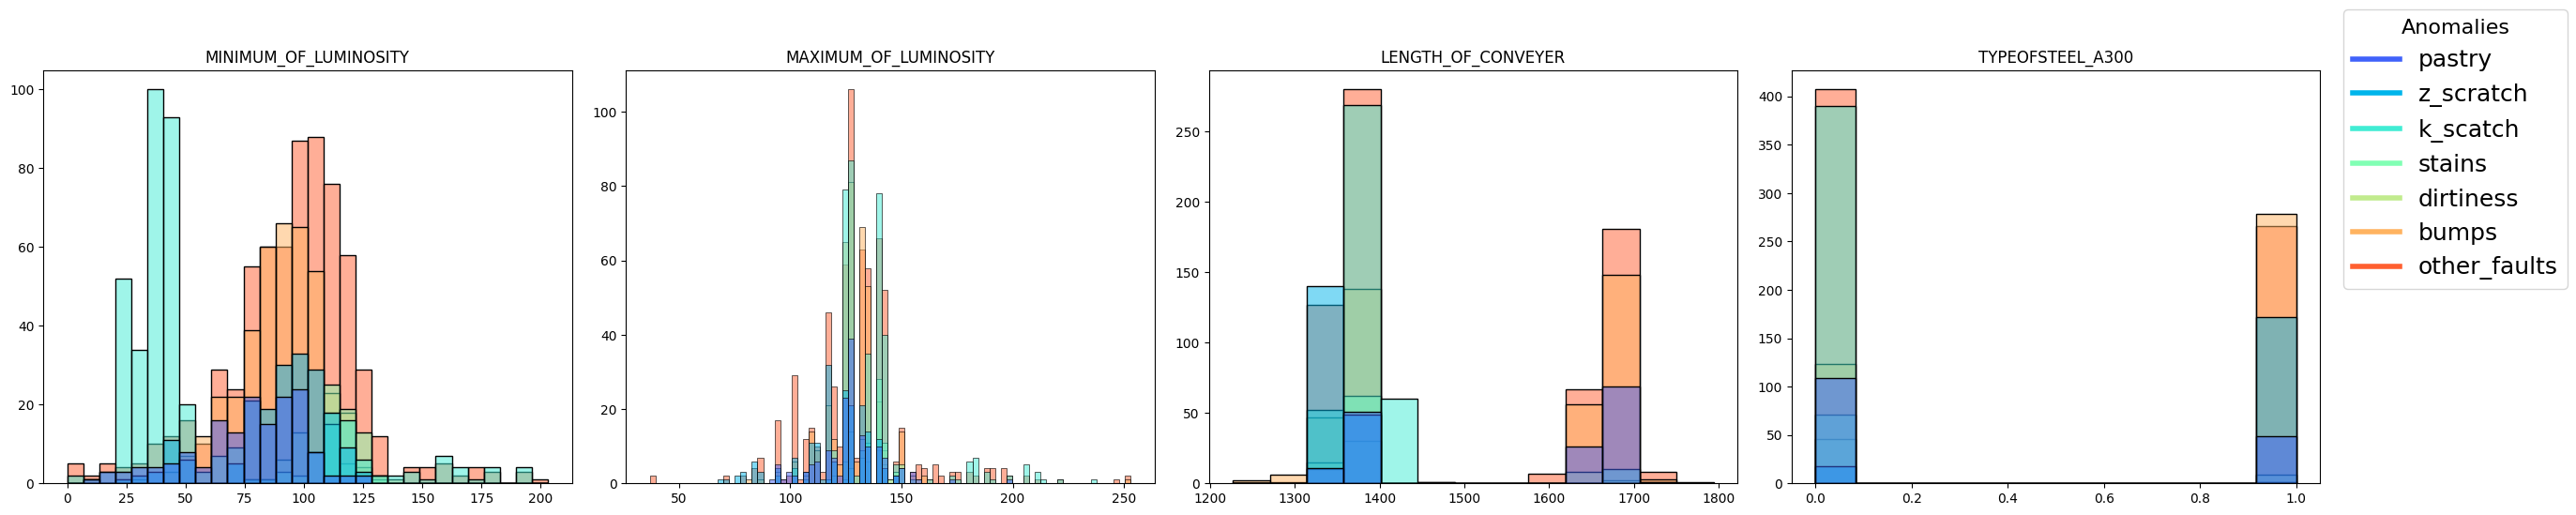

In [131]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

Lenght of conveyer has 2 distinct groups in the histogram, that's why it's an important feature.

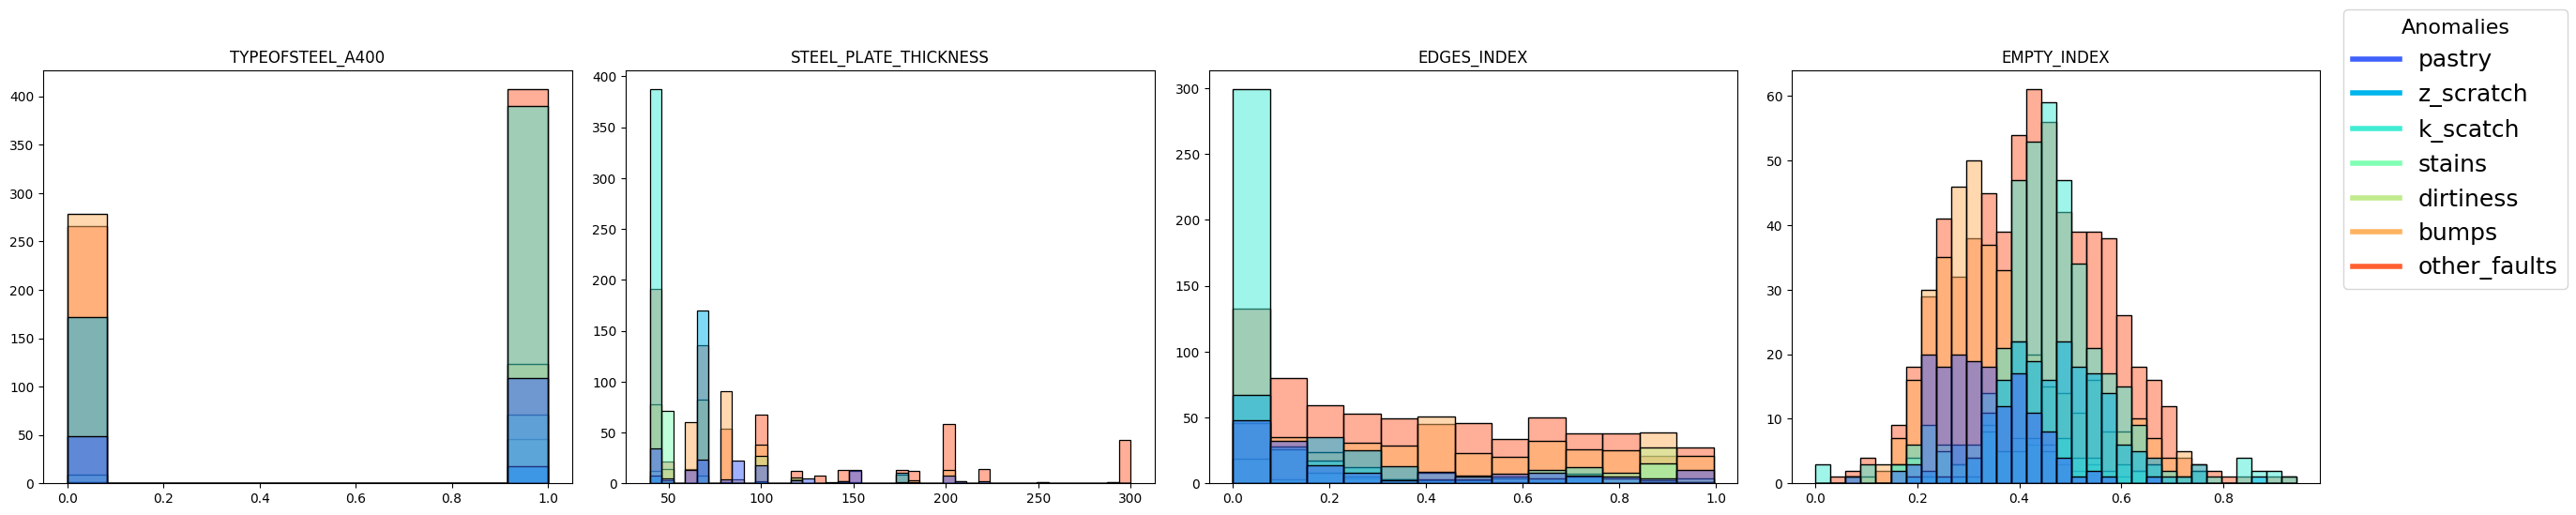

In [132]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

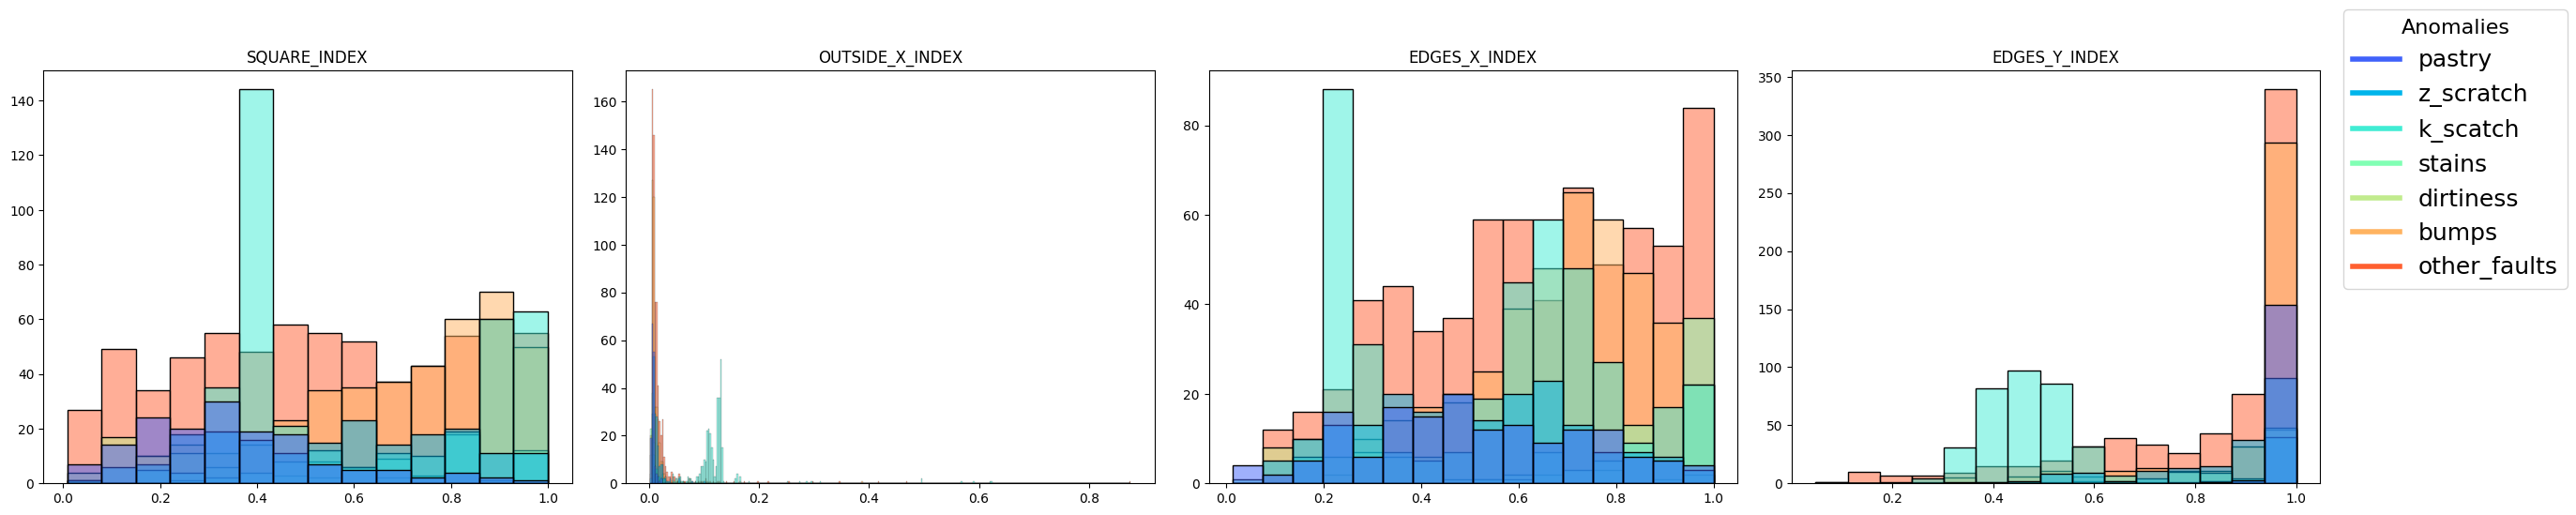

In [133]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

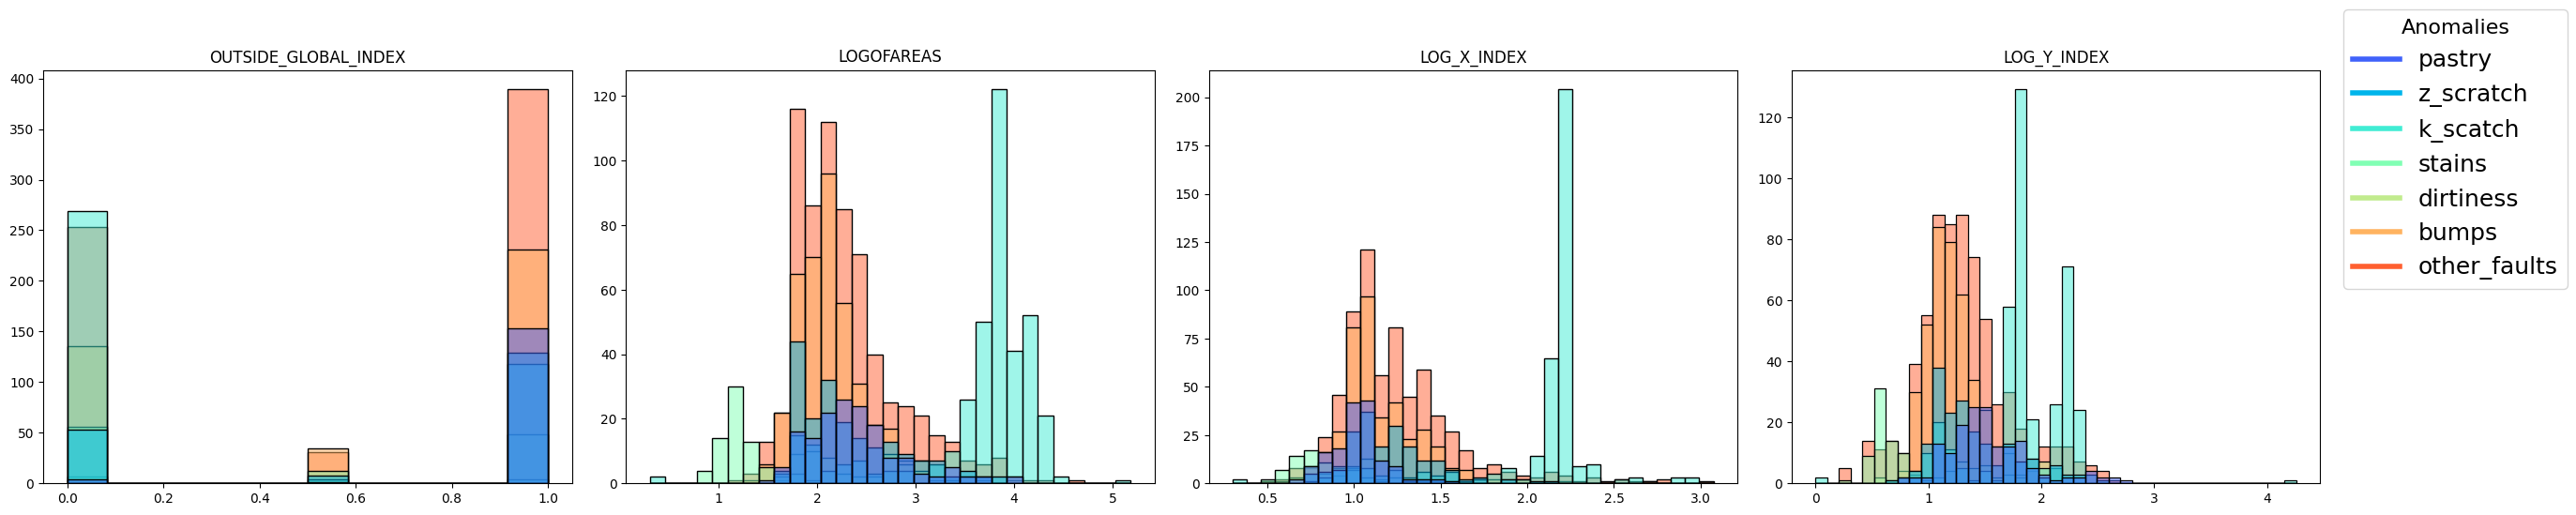

In [134]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

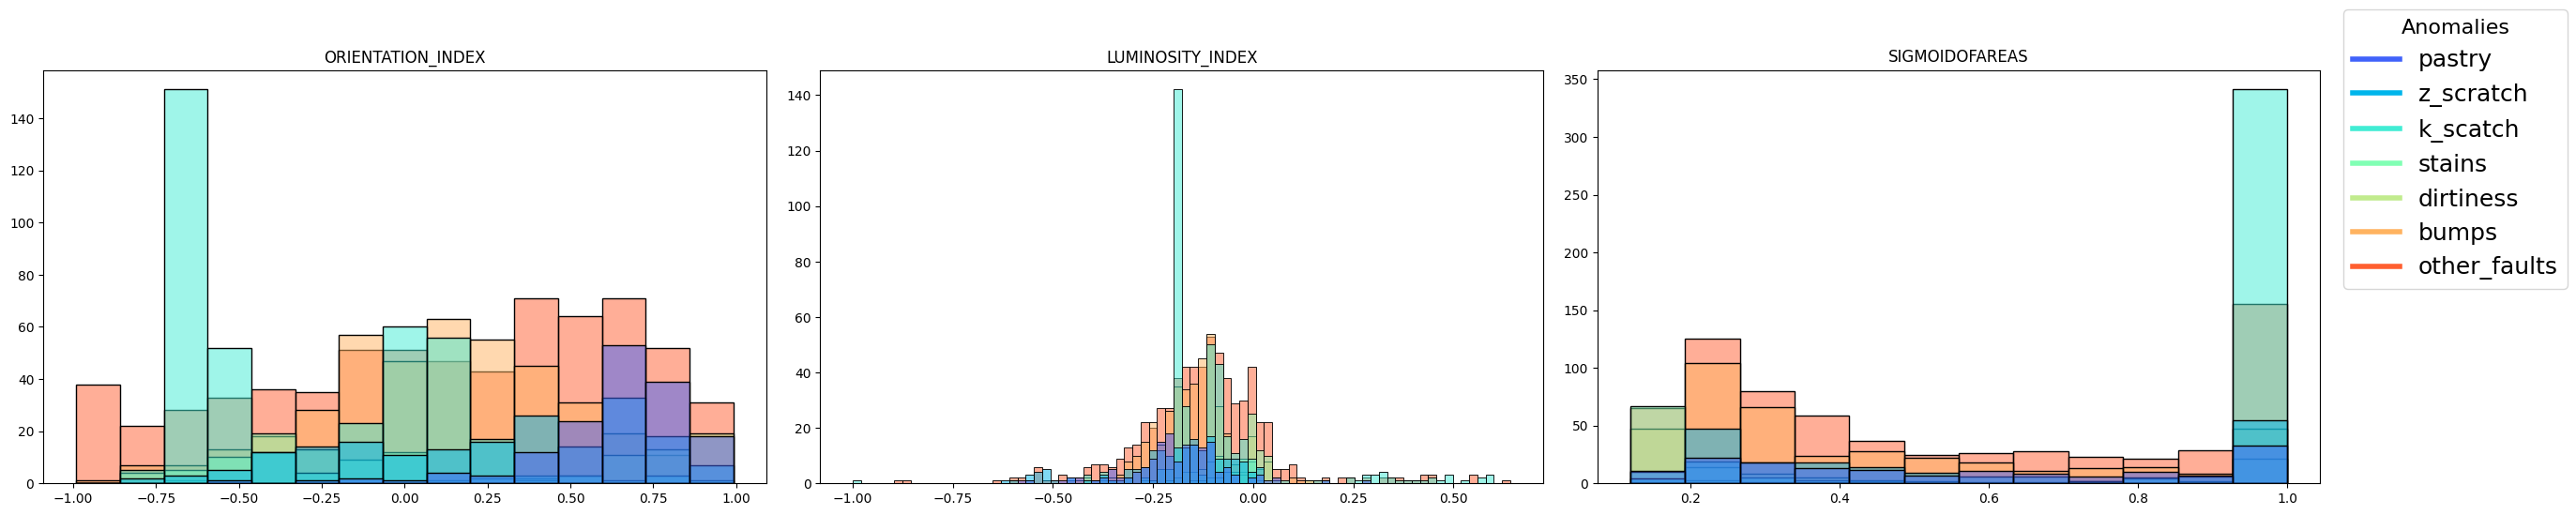

In [135]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

## Boxplots of the features

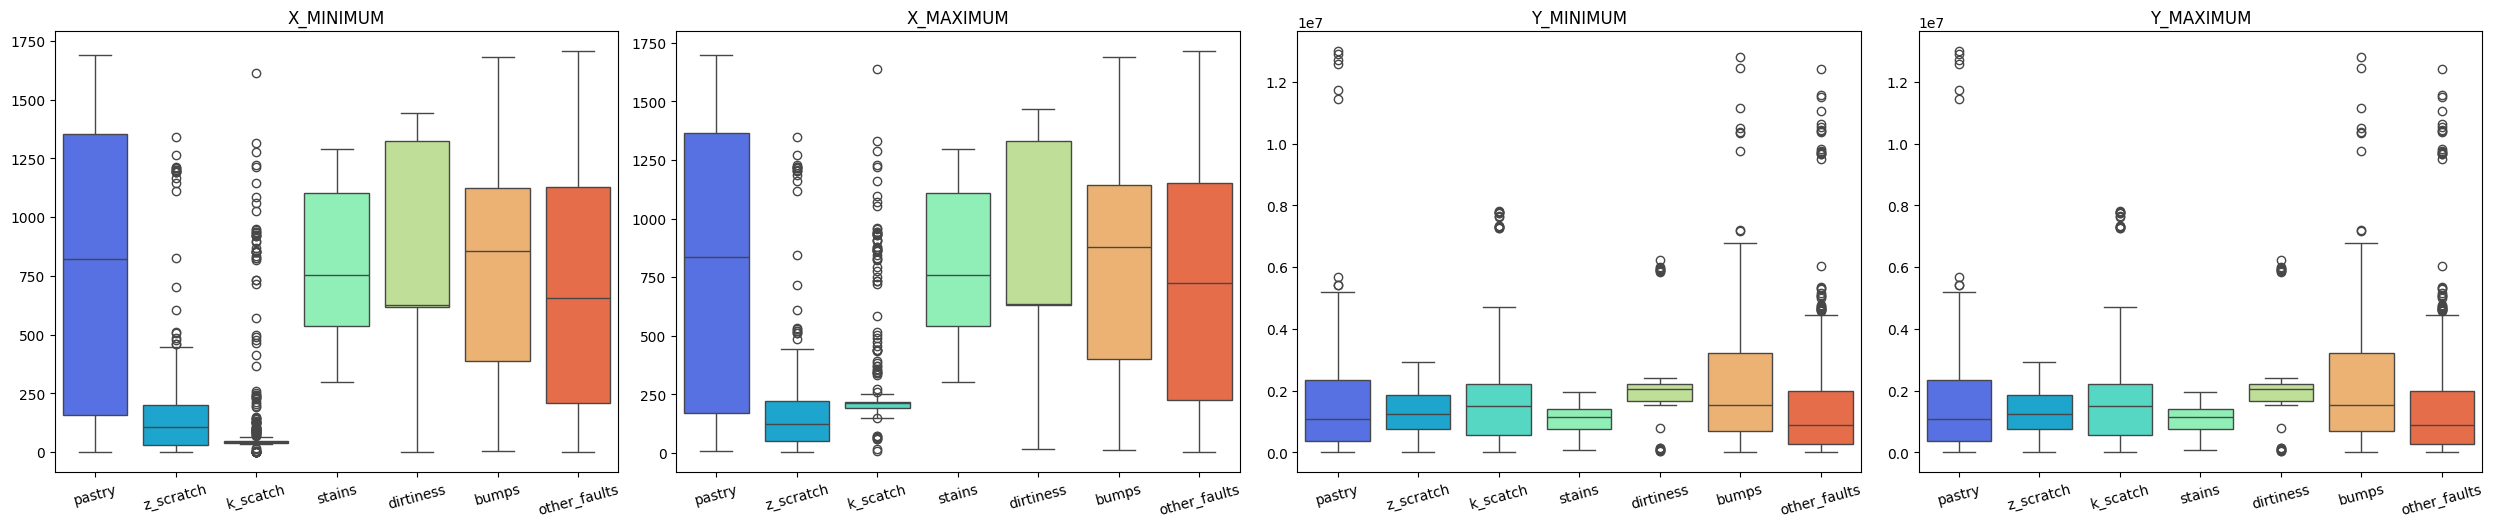

In [136]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

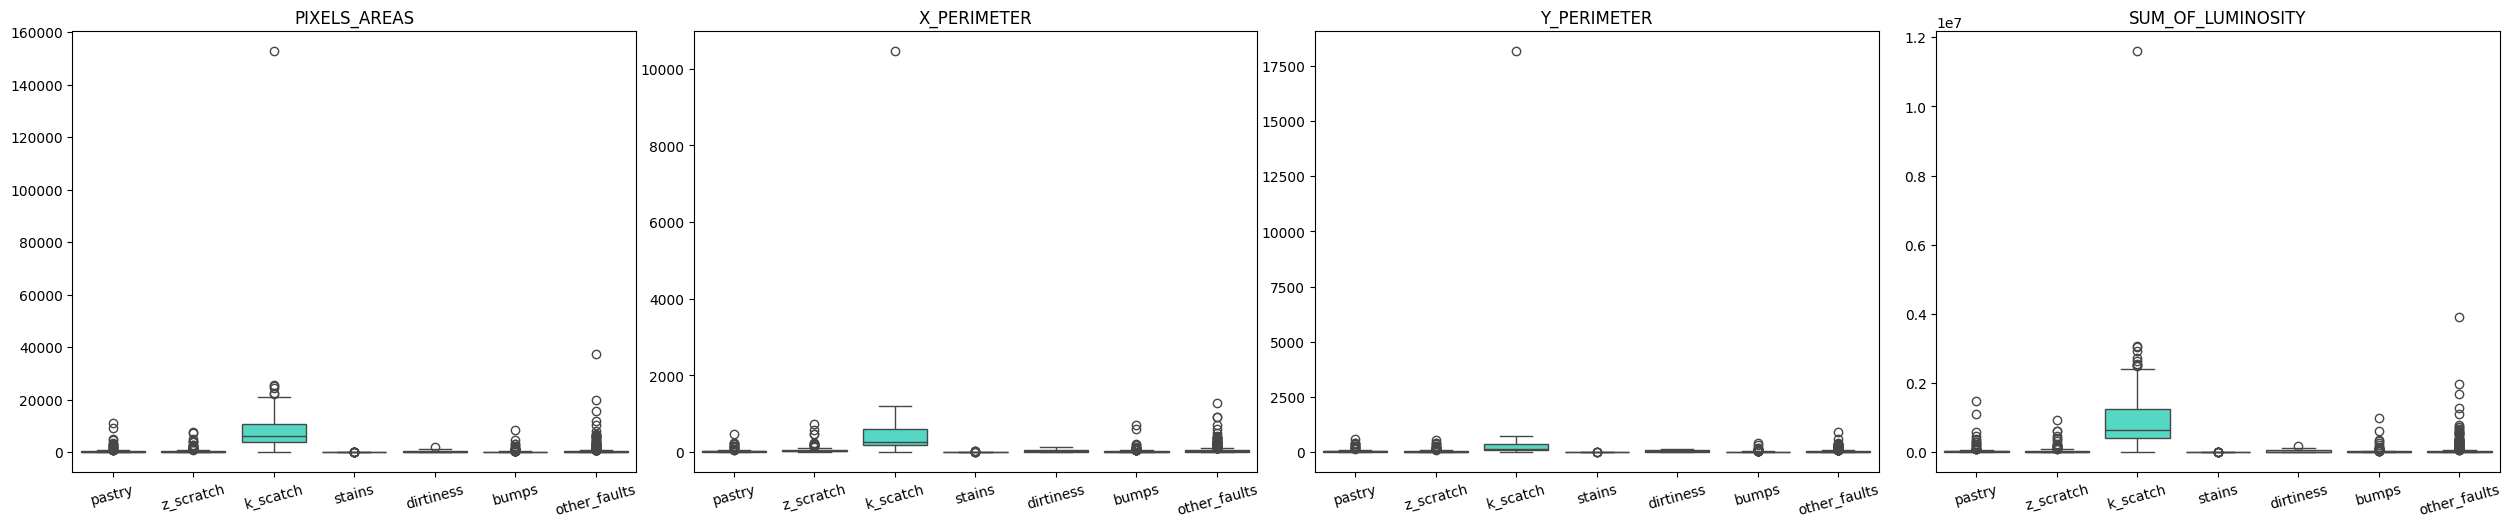

In [137]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

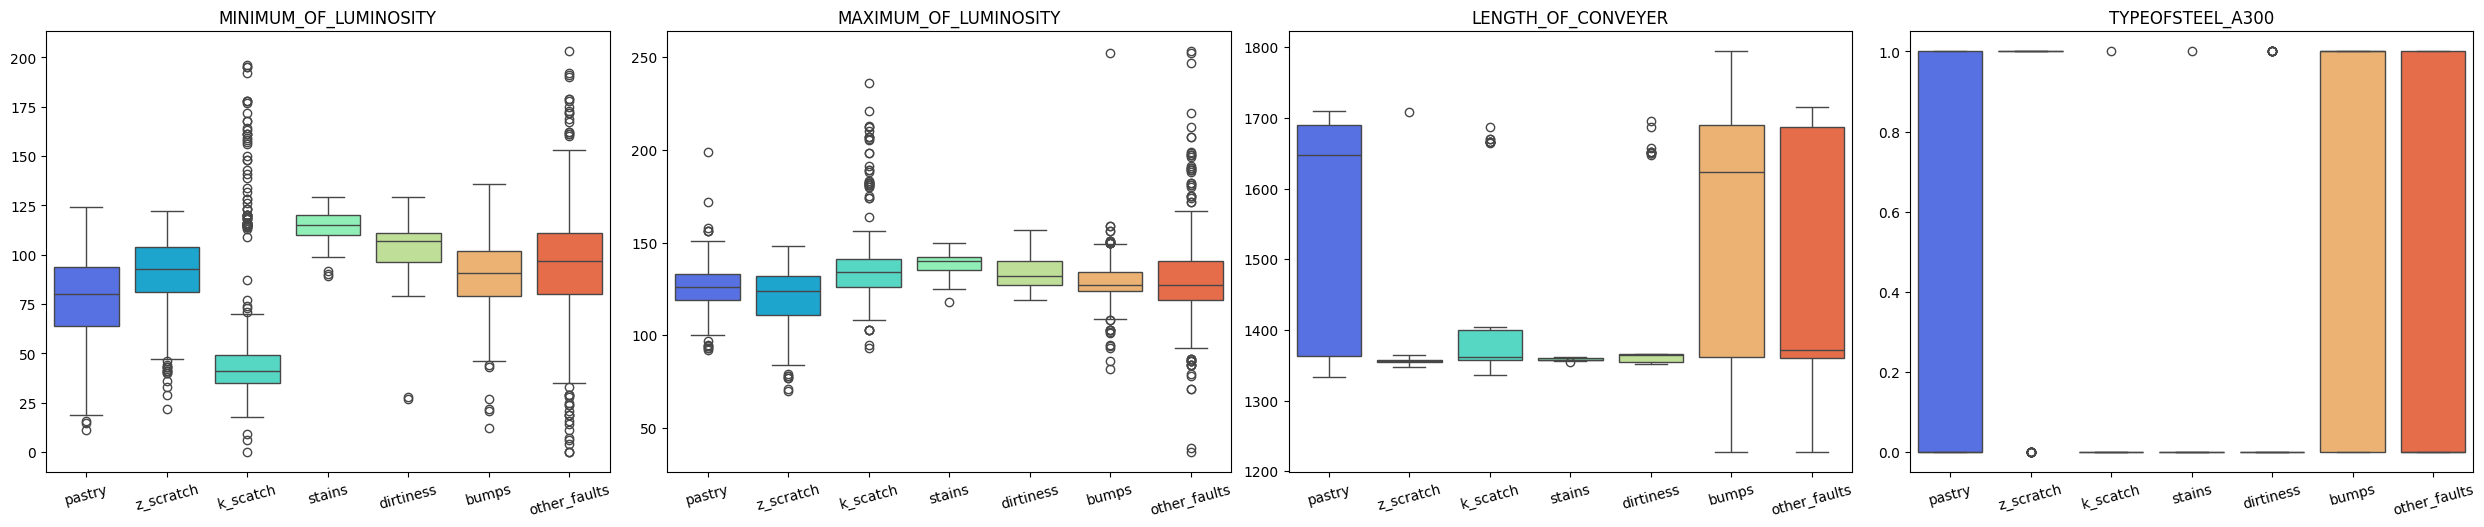

In [138]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

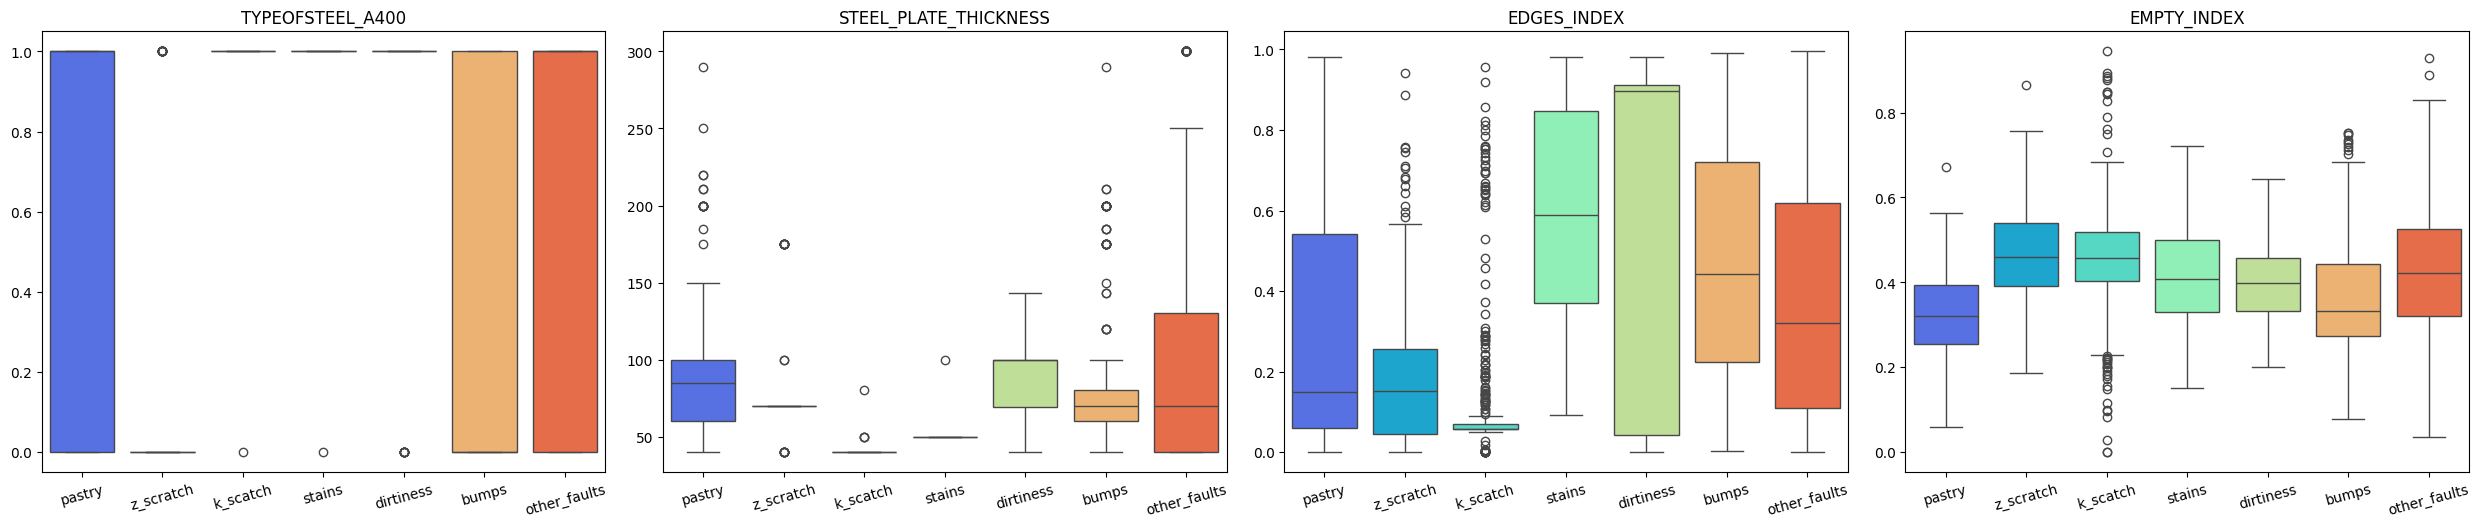

In [139]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

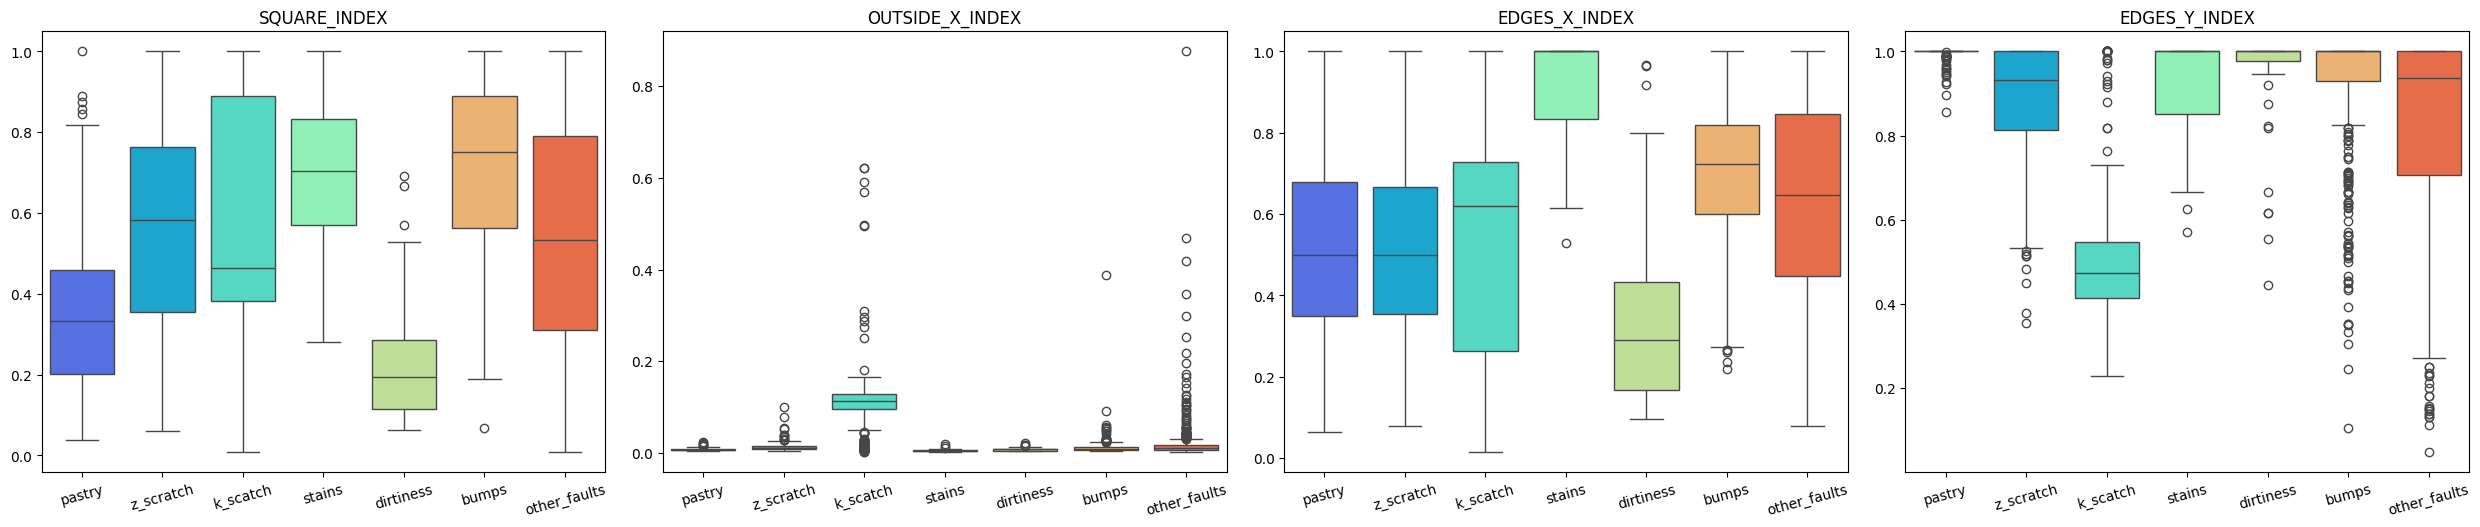

In [140]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

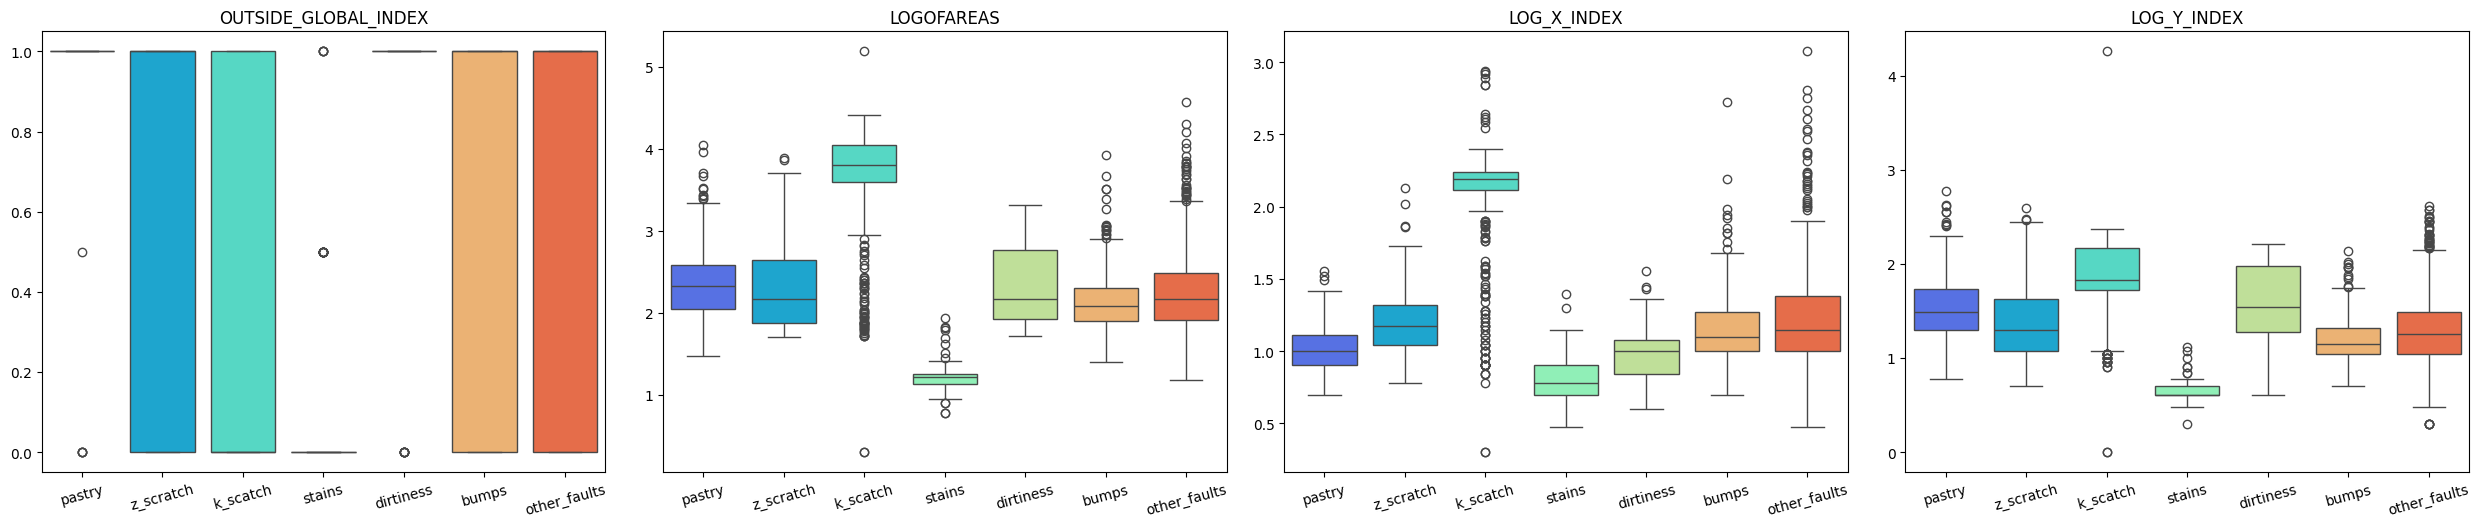

In [141]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

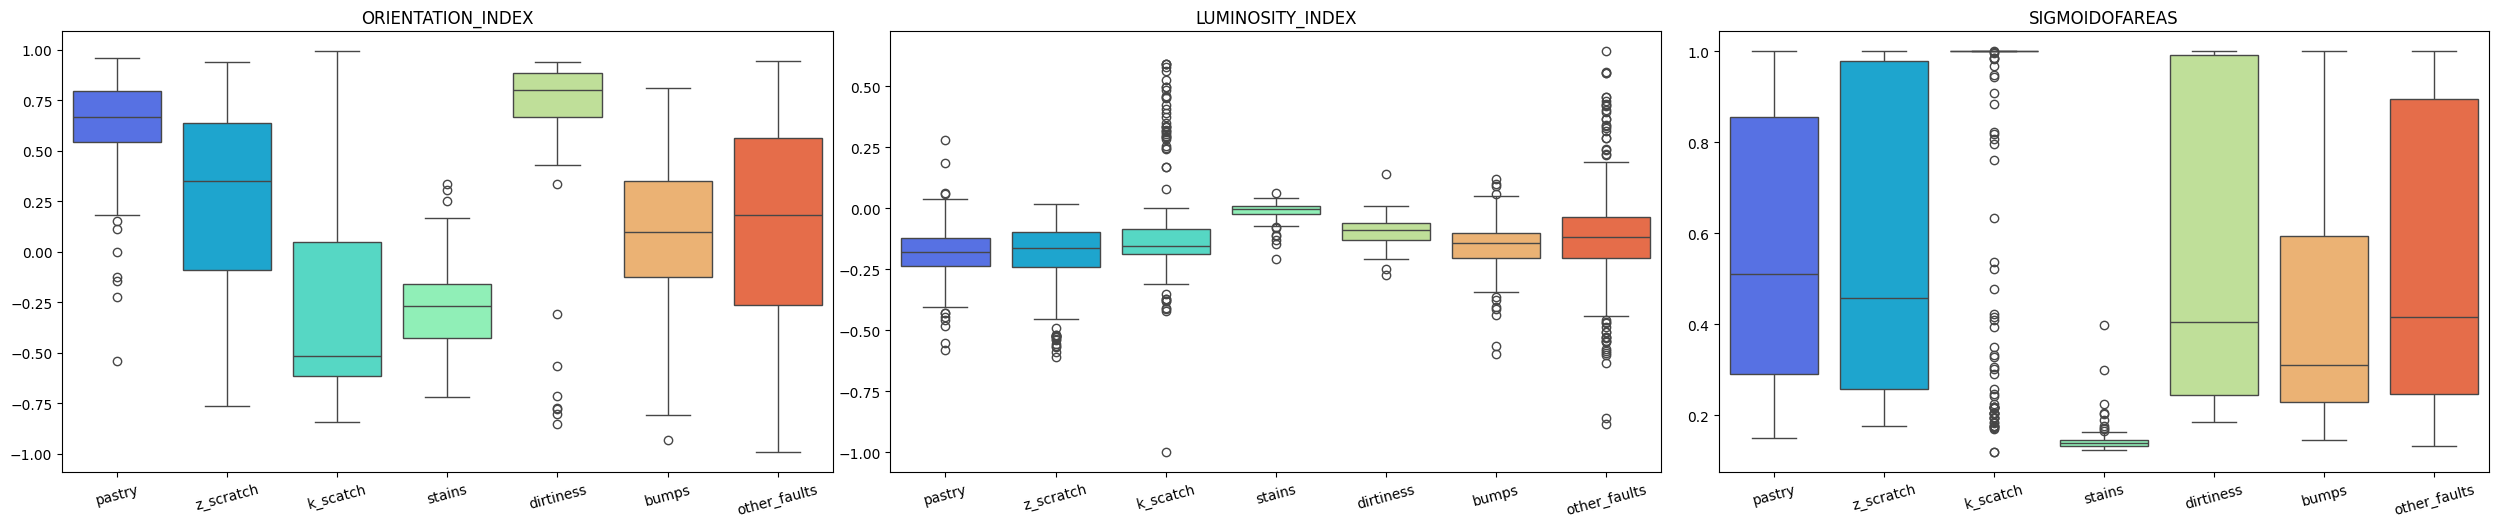

In [142]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [143]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


## Balancing the classes

Display how the anomalies are divided in the dataset

In [144]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

,count
pastry,158
z_scratch,190
k_scatch,391
stains,72
dirtiness,55
bumps,402
other_faults,673


In [145]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


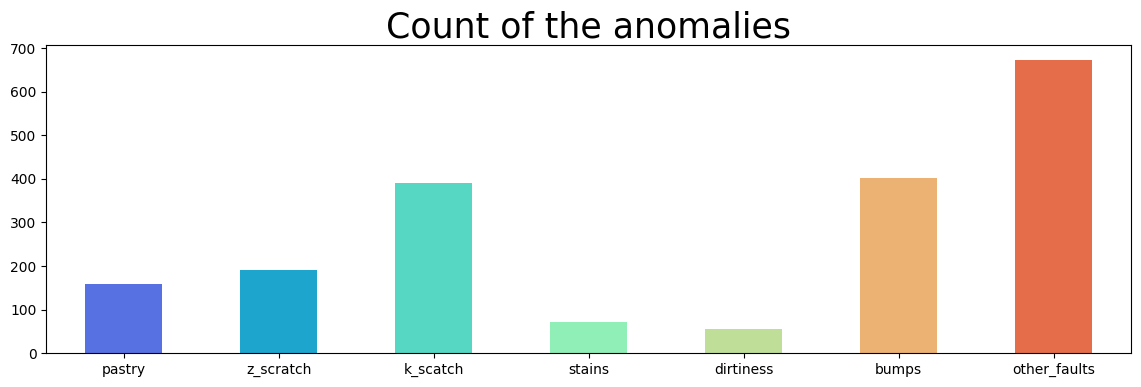

In [146]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [147]:
sm = SMOTE(random_state = 2)

In [148]:
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)

In [149]:
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)

In [150]:
anomaly_count_res = pd.DataFrame(df_res['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,673
z_scratch,673
k_scatch,673
stains,673
dirtiness,673
bumps,673
other_faults,673


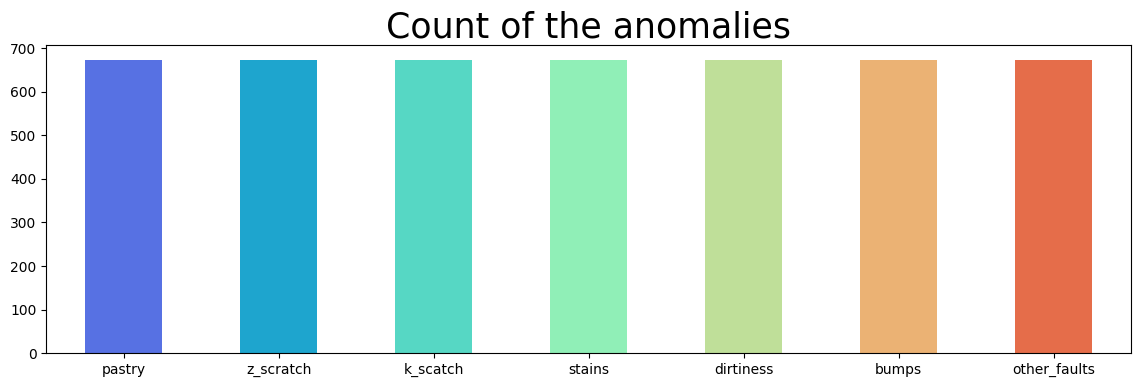

In [151]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Outlier detection 

From the boxplots we can clearly see that the dataset seems to present a lot of outliers. Check if these samples need to be removed or not

In [152]:
df_iqr = df.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]
df_iqr[target_cols] = df[target_cols]

In [153]:
anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
anomaly_count_iqr
anomaly_count_iqr.index = target_cols
display(anomaly_count_iqr, anomaly_count_iqr - anomaly_count)
lost_samples = round((len(df) - len(df_iqr)) / len(df), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
del df_iqr, anomaly_count_iqr

,count
pastry,103
z_scratch,150
k_scatch,23
stains,72
dirtiness,46
bumps,334
other_faults,389


,count
pastry,-55
z_scratch,-40
k_scatch,-368
stains,0
dirtiness,-9
bumps,-68
other_faults,-284


The dataset lost 42.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the dataset, lost 368 samples remaining with only 24. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 42% of the dataset would be lost if we applied this outlier detection.

## Correlation between features

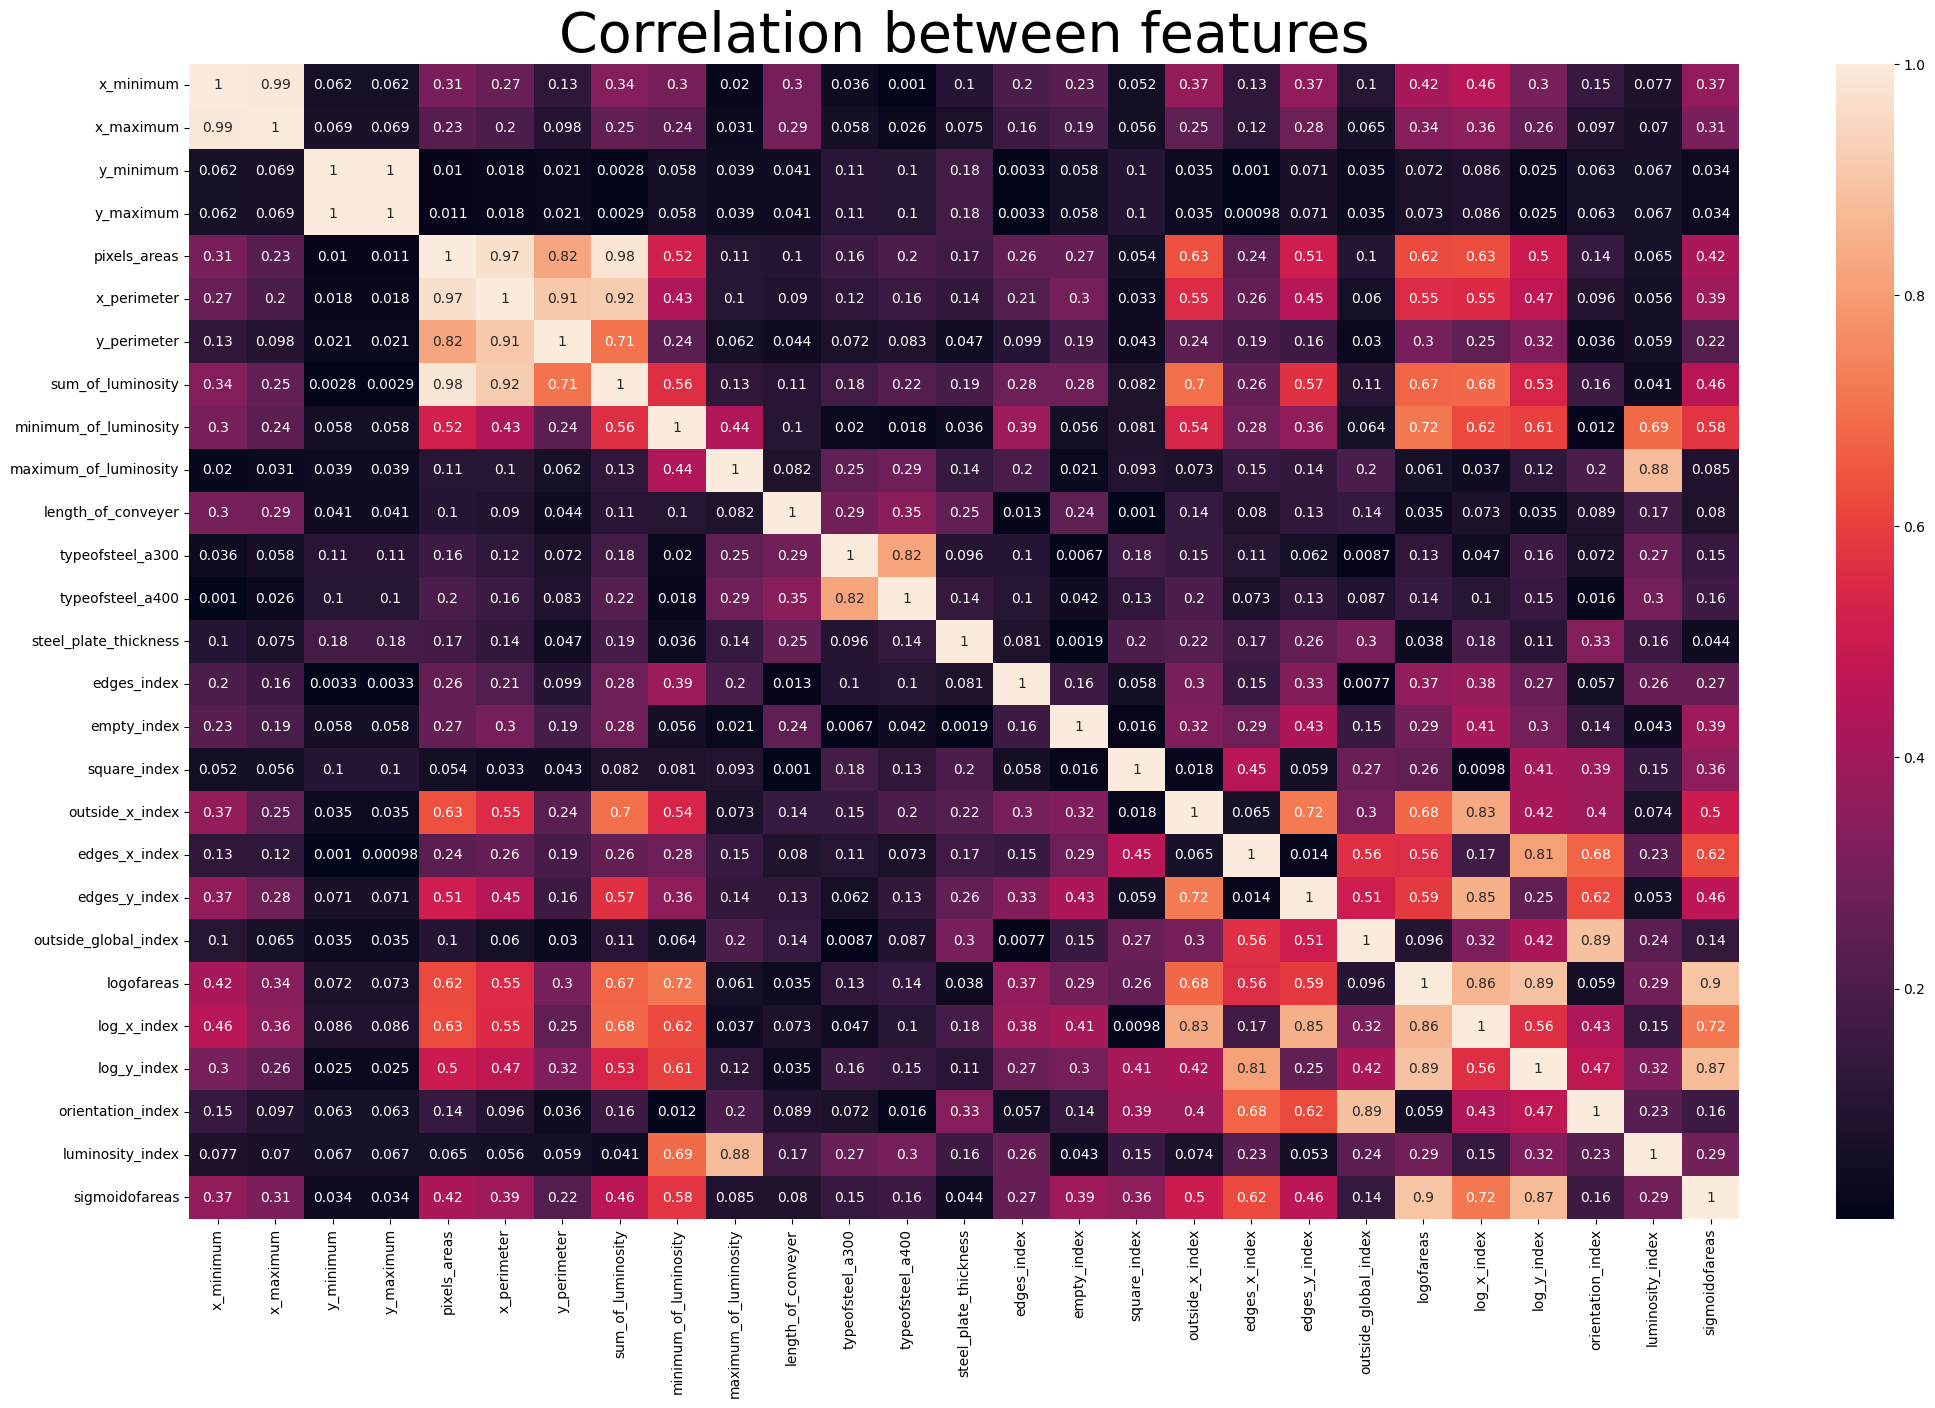

In [154]:
corr = df_res[feat_col].corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
plt.show()

In [155]:
threshold = 0.7

mask = np.triu(np.ones(corr.shape), k=1)

# Find feature pairs with high correlation
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i in range(corr.shape[0])
    for j in range(corr.shape[1])
    if mask[i, j] and corr.iloc[i, j] > threshold
]

high_corr_pairs = pd.DataFrame(high_corr_pairs).T
high_corr_pairs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,x_minimum,y_minimum,pixels_areas,pixels_areas,pixels_areas,x_perimeter,x_perimeter,y_perimeter,minimum_of_luminosity,maximum_of_luminosity,typeofsteel_a300,outside_x_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,logofareas,logofareas,log_x_index,log_y_index
1,x_maximum,y_maximum,x_perimeter,y_perimeter,sum_of_luminosity,y_perimeter,sum_of_luminosity,sum_of_luminosity,logofareas,luminosity_index,typeofsteel_a400,edges_y_index,log_x_index,log_y_index,log_x_index,orientation_index,log_x_index,log_y_index,sigmoidofareas,sigmoidofareas,sigmoidofareas
2,0.991261,1.0,0.969444,0.821836,0.981029,0.906474,0.920811,0.705848,0.718601,0.877901,0.817277,0.722203,0.828291,0.805444,0.851693,0.88938,0.860774,0.893738,0.895809,0.718343,0.874383


We see that a lot of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 (but even 0.7). This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [156]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,sum_of_luminosity
x_minimum,NaN,0.991261,NaN,NaN,NaN,NaN,NaN
x_maximum,0.991261,NaN,NaN,NaN,NaN,NaN,NaN
y_minimum,NaN,NaN,NaN,1.0,NaN,NaN,NaN
y_maximum,NaN,NaN,1.0,NaN,NaN,NaN,NaN
pixels_areas,NaN,NaN,NaN,NaN,NaN,0.969444,0.981029
x_perimeter,NaN,NaN,NaN,NaN,0.969444,NaN,NaN
sum_of_luminosity,NaN,NaN,NaN,NaN,0.981029,NaN,NaN


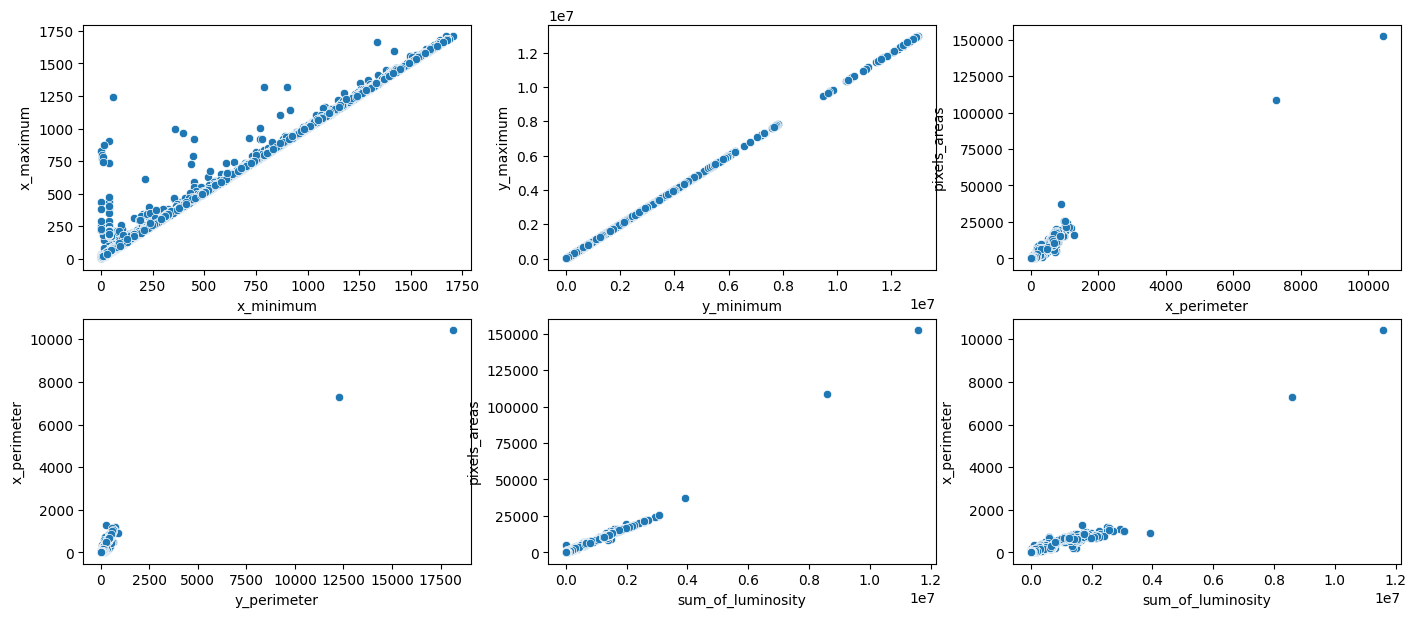

In [157]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
plt.tight_layout

sns.scatterplot(data = df_res, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df_res, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df_res, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df_res, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df_res, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df_res, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

Later in the notebook, dimensionality reduction through UMAP is applied. Since UMAP handles well non-linear relationships, it might not be worth it trying to aggregate all of the highly correlated features. However, we will aggregate the ones displayed in the last graph, since they have almost perfect linear correlation and we will lower the feature dimension, making UMAP more computationally efficient while loosing very little information.

## Normalize the data

Since normalizing binary data doesn't make sense->remove the binary features, normalize the remaining features and then re-add the binary ones.

In [158]:
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)

In [159]:
sc = StandardScaler()
# normalize the non binary dataframe
nonbin_norm = sc.fit_transform(df_nonbin)
# transform the standardized array into a dataframe
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
# copy the non binary dataframe, so that we can add binary features to the new one
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
del nonbin_norm
df_norm.head()

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,typeofsteel_a300,typeofsteel_a400,outside_global_index,anomaly
0,-1.173949,-1.281522,-0.820242,-0.820241,-0.264058,-0.281053,-0.072934,-0.298214,-0.454606,-1.437448,1.926338,0.131984,-1.021062,-1.387924,-1.302274,-0.415075,-0.482226,0.689223,0.138763,-0.668993,0.603049,1.286426,-1.332115,0.149064,1,0,1.0,0
1,0.070175,0.012071,0.506535,0.506521,-0.301792,-0.309862,-0.114992,-0.328525,-0.174962,-0.464188,1.926338,0.131984,1.296569,-0.236459,-1.208203,-0.438067,0.021656,0.525559,-0.361423,-0.947727,0.225825,1.237250,-0.426791,-0.696790,1,0,1.0,0
2,0.449809,0.408113,-0.069409,-0.069427,-0.310572,-0.318093,-0.148037,-0.336622,0.349368,-0.334419,1.432025,0.596084,1.965372,-0.543126,-0.734473,-0.435977,0.605754,0.430702,-0.593130,-0.947727,-0.205557,0.989611,-0.013644,-0.945360,1,0,1.0,0
3,0.499326,0.461923,-0.762616,-0.762615,-0.285654,-0.297515,-0.069930,-0.310563,0.349368,-0.269535,-0.653354,5.005030,1.179861,0.281617,-1.400468,-0.404625,-0.217824,0.689223,-0.091544,-0.798429,0.623254,1.337756,-0.279686,-0.032744,0,1,1.0,0
4,1.398892,1.421894,-0.687295,-0.687170,0.244273,-0.104083,0.575955,0.228234,-1.817866,-0.269535,-0.653354,2.568507,-0.957196,0.342616,-1.735526,-0.249954,-1.211570,0.632702,1.354300,0.061654,2.199431,1.512906,-0.611455,1.394300,0,1,1.0,0


In [160]:
# check for standardization
norm_dict = {}
for col in feat_col:
    norm_dict[col] = [round(df_norm[col].mean(), 5), round(df_norm[col].var(), 5)]
    if col == feat_col[-1]:
        display(pd.DataFrame(norm_dict, index = ['Mean', 'Variance']))

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,typeofsteel_a300,typeofsteel_a400,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas
Mean,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.30652,0.60178,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.60135,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000
Variance,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,0.21261,0.23969,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021,0.20982,1.00021,1.00021,1.00021,1.00021,1.00021,1.00021


Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

## Aggregate features

Aggregate features that have high correlation

In [161]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)

df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)

df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)

df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)

df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)

df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

## Visualizing the classes

Perform a dimensionality reduction so that we can visualize the classes in a 3 dimensional space.

First try with PCA

In [162]:
pca = PCA(n_components = 3)  
X = df_norm.drop('anomaly', axis = 1)
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

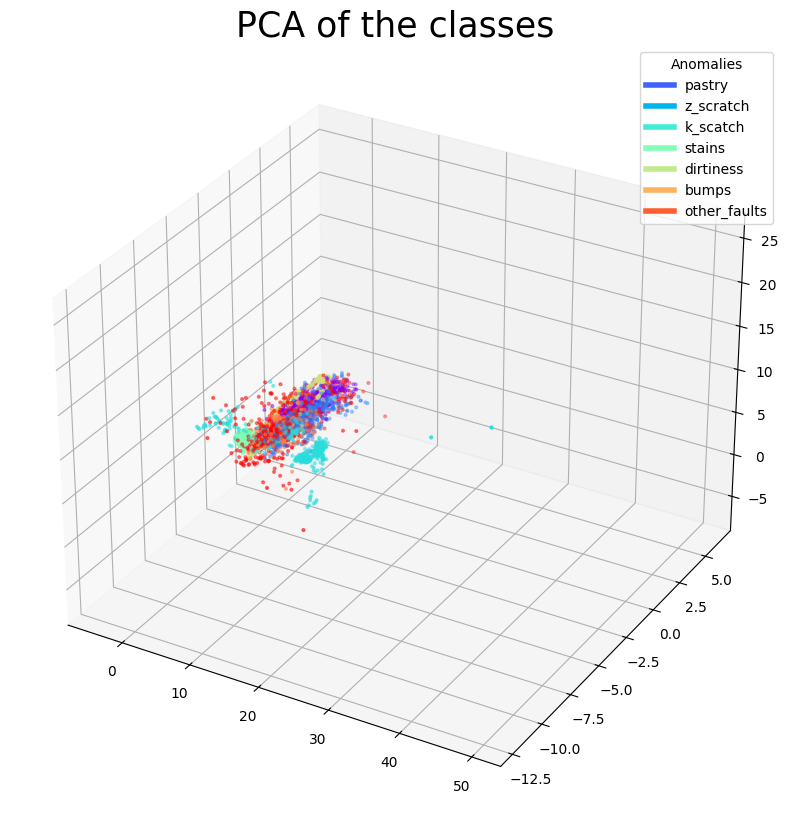

In [175]:
#%matplotlib qtagg 
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

UMAP

In [176]:
ump = umap.UMAP(n_neighbors = 5, n_components = 3, random_state = 2)

df_umap = ump.fit_transform(df_norm)

df_umap = pd.merge(pd.DataFrame(df_umap), df_norm['anomaly'], left_index = True, right_index = True)

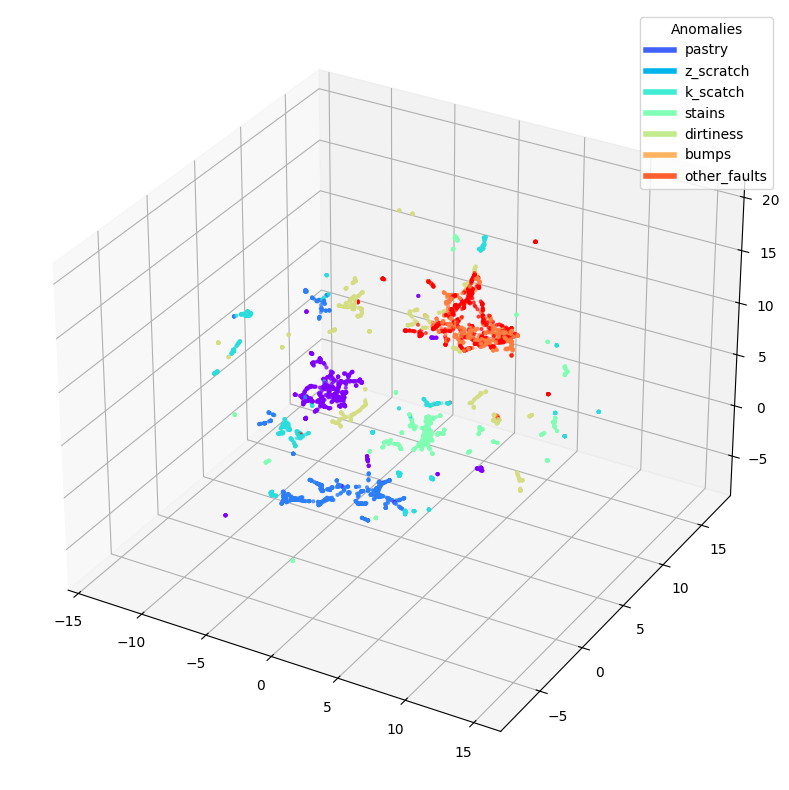

In [177]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(df_umap[0], df_umap[1], df_umap[2], c = df_umap['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

t-SNE

In [167]:
tsne = TSNE(n_components = 3, random_state = 2)

df_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(df_tsne, columns = ['PC1', 'PC2', 'PC3'])
df_tsne['anomaly'] = df_norm['anomaly']

In [168]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(df_tsne['PC1'], df_tsne['PC2'], df_tsne['PC3'], c = df_tsne['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP and t-SNE do a better job then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use the UMAP/t-SNE dimensionality reducted dataframes insteand of the original one or the PCA one.

## Actual dimensionality reduction

In [178]:
ump = umap.UMAP(n_neighbors = 5, n_components = 10, random_state = 2)

pipeline = Pipeline([('umap', ump), ('scaler', sc)])

df_umap = pipeline.fit_transform(df_norm)

df_umap = pd.merge(pd.DataFrame(df_umap), df_norm['anomaly'], left_index = True, right_index = True)

## Naive Bayes

In [170]:
gnb = GaussianNB()

In [203]:
X = df_umap.drop('anomaly', axis = 1)
y = df_umap['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 2)

In [172]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

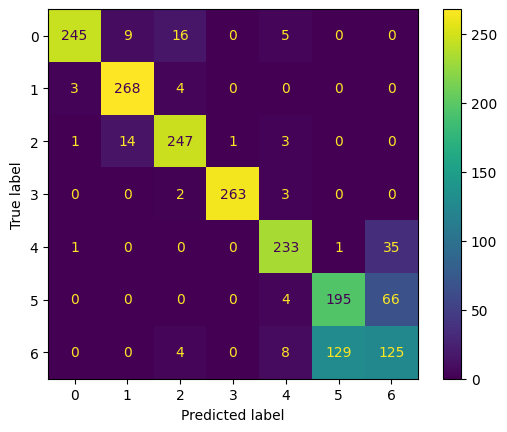

In [173]:
matplotlib.use('inline')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [174]:
gnb_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for naive bayes classifier: {gnb_accuracy}%')

Accuracy score for naive bayes classifier: 0.84%


As we've seen in the UMAP visualization of the classes, class 5 and 6 are difficultly differentiable. This is confirmed by the the latter confusion matrix. We might try using some hyperparameter tuning/priors/loss balanced learning in the case of the naive bayes classifier

## Support Vector Classifier

In [179]:
svm = SVC()

In [180]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

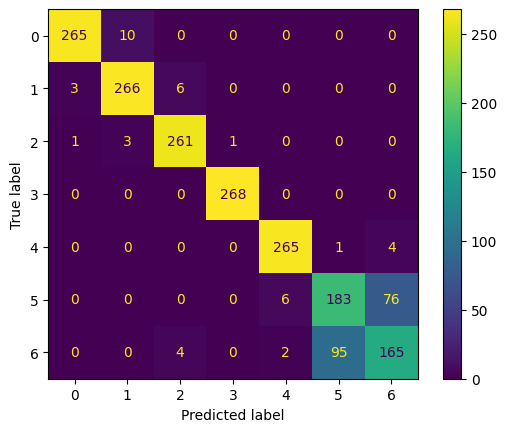

In [181]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [182]:
svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for SVM: {svm_accuracy}%')

Accuracy score for SVM: 0.89%


Hyperparameter tuning for SVM

In [183]:
parameters = {'C' : [1, 50000, 100000, 500000, 1000000]}

svc = SVC()

clf = GridSearchCV(svc, parameters, scoring = 'accuracy', verbose = 1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 50000, 100000, 500000, 1000000]},
             scoring='accuracy', verbose=1)

In [184]:
y_pred = clf.predict(X_test)

In [185]:
clf.best_params_

{'C': 50000}

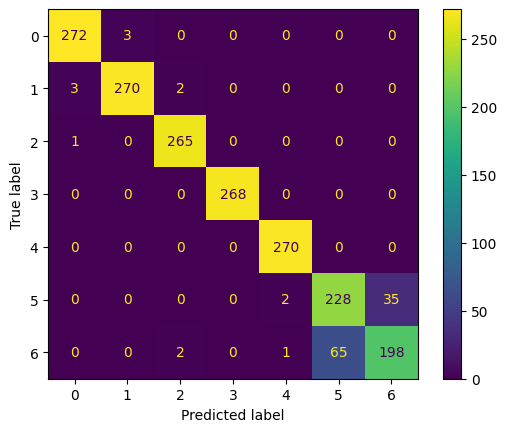

In [186]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [187]:
svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for SVM: {svm_accuracy}%')

Accuracy score for SVM: 0.94%


Autoencoder feature extraction

NEXT STEPS

check if feature aggregation is worth it, hyp tuning, feat eng polynomial features, Apply transformations like log, sqrt, or Box-Cox for skewed features, data augmentation, test autoencoders or feature extraction with deep learning models, use pre-trained models or transfer learning if applicable.

Ideas for the models:

2) simple DNN
3) Bayes with features extracted by an autoencoder
4) SVM with features extracted by an autoencoder